# Applied GenAI: Text to Image Generation

## Fine-Tuning Stable Diffusion for Custom Shoe Design

While the base Stable Diffusion model is a generalist capable of creating a vast range of images, its output for specific domains can be inconsistent. To address this, we will perform fine-tuning, a process where we train the model on a curated dataset to specialize its knowledge. By using Low-Rank Adaptation (LoRA), a parameter-efficient fine-tuning technique, we can achieve this specialization with significantly fewer computational resources compared to traditional training methods.

This notebook documents the end-to-end process of transforming a general-purpose model into a specialist tool for generating unique and high-quality images of shoes.

## Objectives

1. **Fine-Tune a Diffusion Model:** Adapt the pre-trained Stable Diffusion v1.5 model to specialize in generating shoe imagery using the UT Zappos50K dataset.

2. **Implement Efficient Training:** Utilize the LoRA (Low-Rank Adaptation) technique to perform fine-tuning in a computationally and memory-efficient manner.

3. **Validate the Training Process:** Monitor and visualize the model's training loss to ensure it is effectively learning the stylistic features of the shoe dataset.

4. **Develop an Interactive Application:** Deploy the fine-tuned model as an interactive web demo using Gradio, allowing users to generate custom shoe designs from text prompts.

 Installing diffusers, a core library from Hugging Face that provides the tools to work with diffusion models like Stable Diffusion.

In [ ]:
!pip install diffusers

Installing additional libraries required for the fine-tuning process and for creating an interactive demo.

* **invisible_watermark:** A tool for adding a watermark to the generated images to identify them as AI-created.

* **transformers and accelerate:** Supporting libraries from Hugging Face for efficient model loading and execution.

* **safetensors:** A secure and fast file format for storing model weights.

* **peft:** The Parameter-Efficient Fine-Tuning library allows us to use techniques like LoRA, which significantly reduces the computational resources required for training.

* **datasets:** A Hugging Face library for easily loading and processing our image dataset.

* **bitsandbytes:** Provides memory-efficient optimizers and quantization, crucial for training large models on consumer-grade hardware.

In [ ]:
!pip install invisible_watermark transformers accelerate safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
!pip install peft datasets bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 11.5 MB/s eta 0:00:00


## Prepare Workspace and Acquiring the Training Data.

* **Mount Google Drive:** We connect to Google Drive to create a persistent storage location. This is where we will save our final fine-tuned model weights, ensuring our work isn't lost when the Colab session ends.

* **Download and Unzip Data:** We download the UT Zappos50K dataset, a large collection of shoe images. The !wget command fetches the compressed file, and !unzip extracts the images into our workspace.

In [ ]:
# Mount Google Drive for storage
from google.colab import drive
drive.mount('/content/drive')

# Download UT Zappos50K dataset to a specific folder in Google Drive
# IMPORTANT: Replace 'your_folder_path_in_drive' with the actual path to your desired folder in Google Drive.
# For example: '/content/drive/MyDrive/MyProject/data'
!wget -P '/content/drive/MyDrive/GenAI_MDS_1546' https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip
!unzip -q '/content/drive/MyDrive/GenAI_MDS_1546/ut-zap50k-images-square.zip' -d './'

Mounted at /content/drive
--2025-08-17 06:58:02--  https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.130.185
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.130.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144233542 (138M) [application/zip]
Saving to: ‘/content/drive/MyDrive/GenAI_MDS_1546/ut-zap50k-images-square.zip’

ut-zap50k-images-sq 100%[===================>] 137.55M  54.4MB/s    in 2.5s    

2025-08-17 06:58:05 (54.4 MB/s) - ‘/content/drive/MyDrive/GenAI_MDS_1546/ut-zap50k-images-square.zip’ saved [144233542/144233542]



## Preprocess the Image Dataset

Raw datasets are often inconsistent. To ensure our model trains effectively, we must preprocess the images. This function iterates through the downloaded shoe images and performs two key actions:

1. **Standardize Size:** It resizes every image to a resolution of 512x512 pixels. This uniformity is critical for batch processing during training.

2. **Limit Dataset Size:** To enable faster training for this demonstration, we are selecting a subset of 800 images from the full dataset.

The processed images are then saved to a new directory, ./shoe_dataset/images.

In [ ]:
from PIL import Image
import os

def prepare_colab_dataset(input_dir, output_dir, max_images=800):
    os.makedirs(output_dir, exist_ok=True)
    processed = 0
    for subdir, _, files in os.walk(input_dir):
        for filename in files:
            if processed >= max_images:
                break
            if filename.lower().endswith(('.jpg', '.png')):
                img_path = os.path.join(subdir, filename)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize((512, 512), Image.Resampling.LANCZOS)
                    img.save(os.path.join(output_dir, f"{processed:04d}.jpg"), 'JPEG', quality=85)
                    processed += 1
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    print(f"Prepared {processed} images")

prepare_colab_dataset('./ut-zap50k-images-square', './shoe_dataset/images')

Prepared 800 images


## Generate Image Captions

Diffusion models are trained on image-text pairs. This cell creates a metadata file named captions.jsonl that links each of our 800 preprocessed images to a text description. For this project, since all images are shoes, we are using the simple caption "a photo of a shoe" for every image. This teaches the model to associate this specific text prompt with the visual characteristics of the shoes in our dataset.

In [ ]:
import os
import json

dataset_dir = './shoe_dataset/images'
captions_list = []

for fname in sorted(os.listdir(dataset_dir)):
    if fname.endswith('.jpg') or fname.endswith('.png'):
        # Using a more descriptive, tokenizable caption
        caption = "a photo of a shoe"
        captions_list.append({"file_name": fname, "text": caption})

# Write to captions.jsonl
output_jsonl_path = os.path.join('./shoe_dataset', 'captions.jsonl')
with open(output_jsonl_path, 'w') as f:
    for row in captions_list:
        f.write(json.dumps(row) + "\n")

print("Created captions.jsonl with", len(captions_list), "entries")

# Create a metadata.jsonl file as well, as it's a common format
!cp {output_jsonl_path} {os.path.join('./shoe_dataset/images', 'metadata.jsonl')}

Created captions.jsonl with 800 entries


## Model Architecture

### Stable Diffusion v1.5

Stable Diffusion is a powerful latent diffusion model. Instead of operating in the high-dimensional space of pixels, it works in a compressed "latent" space, making it much more efficient. Its architecture has three main components:

* **Text Encoder (CLIP):** This component takes our input prompt (e.g., "a photo of a shoe") and converts it into a numerical representation (an embedding) that the model can understand.

* **UNet:** This is the heart of the diffusion process. It takes the text embedding and a noisy latent image as input and progressively removes the noise. It "imagines" the final image by learning to reverse the noising process. This is the component we will be fine-tuning.

* **Variational Autoencoder (VAE):** The VAE acts as a translator. It compresses the full-resolution training images into the smaller latent space for the UNet to work on. After the UNet has finished denoising, the VAE decodes the final latent representation back into the high-resolution pixel image that we see.


### LoRA (Low-Rank Adaptation)

Fine-tuning the entire Stable Diffusion model, which has billions of parameters, is computationally expensive. LoRA is a parameter-efficient fine-tuning (PEFT) technique that solves this problem.

Instead of retraining the entire model, LoRA injects small, trainable "adapter" layers (low-rank matrices) into the existing layers of the model (in our case, the UNet). During training, only these tiny new layers are updated, while the massive original model weights remain frozen. This allows us to capture the specific style of our dataset (shoes) with a fraction of the computational cost and storage, as we only need to save the small LoRA weights.

## Load the Model and Configure LoRA

Here, we load the pre-trained Stable Diffusion model and prepare it for our LoRA fine-tuning process.

1. **Load Pipeline:** We load the runwayml/stable-diffusion-v1-5 model using the DiffusionPipeline class. We specify torch.float16 for data type to enable mixed-precision, which speeds up training and reduces memory usage on modern GPUs.

2. **Configure LoRA:** We define a LoraConfig that specifies how the LoRA adapters will be applied.

  * r=16: Sets the rank (or dimensionality) of the adapter layers. A higher rank can capture more detail but increases the number of trainable parameters.

  * lora_alpha=16: A scaling factor that controls the magnitude of the LoRA modifications.

  * target_modules: We tell PEFT to specifically inject the LoRA layers into the to_q (query) and to_v (value) attention blocks within the UNet, which is a proven strategy for effective fine-tuning.

3. **Apply to UNet:** Finally, get_peft_model wraps the UNet with the configured LoRA layers, making it ready for training.

In [ ]:
from diffusers import DiffusionPipeline
from peft import LoraConfig, get_peft_model
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = DiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
).to("cuda")

# Freeze all original model parameters
pipe.unet.requires_grad_(False)
pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)

# Configure and apply LoRA
lora_config = LoraConfig(
    r=16, # Increased rank for better detail capture
    lora_alpha=16,
    target_modules=["to_q", "to_v", "to_k", "to_out.0"], # Targeting more attention blocks
    lora_dropout=0.1,
    bias="none",
)

pipe.unet = get_peft_model(pipe.unet, lora_config)
pipe.unet.print_trainable_parameters()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

trainable params: 3,188,736 || all params: 862,709,700 || trainable%: 0.3696


## Training The Model

This is the most critical step. Here, we implement the training loop that will fine-tune our model. This script uses the diffusers training paradigm, which is highly optimized for this task.

1. **Dataset Preparation:** We load our metadata.jsonl file and set up transformations to prepare the images (resizing, cropping, and normalizing) and text captions (tokenizing) for the model.

2. **Optimizer Setup:** We use the AdamW optimizer, a standard choice for training deep learning models. Crucially, it is configured to only update the new LoRA parameters within the UNet, keeping the original model frozen.

3. Training Loop:

We iterate through our dataset for a specified number of epochs.

  * In each step, a batch of images and captions is fed to the model.

  * The model calculates the diffusion loss, which measures how well the UNet is learning to denoise the images based on the text prompts.

  * loss.backward() computes the gradients, and optimizer.step() updates the LoRA weights to minimize this loss.

  * The lr_scheduler adjusts the learning rate during training to improve stability and performance.

This process iteratively teaches the model to get better at generating images that match the "shoe" style from our dataset.

In [ ]:
from datasets import load_dataset
from torchvision import transforms
from diffusers.utils import make_image_grid
import torch.nn.functional as F

# 1. Dataset and Dataloader
def preprocess_dataset(examples):
    # Image transformations
    image_transforms = transforms.Compose(
        [
            transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(512),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )
    # Text tokenization
    text_inputs = pipe.tokenizer(
        examples["text"],
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    # Apply image transforms
    images = [image_transforms(image.convert("RGB")) for image in examples["image"]]

    # Prepare final batch
    batch = {
        "pixel_values": torch.stack(images),
        "input_ids": text_inputs.input_ids,
    }
    return batch

# Load and process the dataset
image_dir = './shoe_dataset/images'
dataset = load_dataset("json", data_files=os.path.join(image_dir, "metadata.jsonl"), split="train")

def load_image(batch):
    image_paths = [os.path.join(image_dir, fname) for fname in batch["file_name"]]
    batch["image"] = [Image.open(p) for p in image_paths]
    return batch

dataset = dataset.map(load_image, batched=True).with_transform(preprocess_dataset)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# 2. Optimizer and Scheduler
optimizer = torch.optim.AdamW(
    pipe.unet.parameters(),
    lr=1e-4, # Learning rate
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-08,
)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=20, # Number of training epochs
)


# 3. Training Loop
num_epochs = 20
pipe.unet.train() # Set the UNet to training mode

loss_history = [] # <--- ADD THIS LINE to store loss values

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        # Load batch to GPU
        pixel_values = batch["pixel_values"].to("cuda", dtype=torch.float16)
        input_ids = batch["input_ids"].to("cuda")

        # Get text embeddings
        encoder_hidden_states = pipe.text_encoder(input_ids)[0]

        # Convert latents
        latents = pipe.vae.encode(pixel_values).latent_dist.sample() * pipe.vae.config.scaling_factor

        # Sample noise to add to the latents
        noise = torch.randn_like(latents)
        bsz = latents.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()

        # Add noise to the latents according to the noise magnitude at each timestep
        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

        # Predict the noise residual and compute loss
        noise_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states).sample

        # Calculate the loss
        loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

        # Backpropagation
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    loss_history.append(avg_epoch_loss) # <--- ADD THIS LINE to save the average loss
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_epoch_loss}")

print("Training finished.")

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Epoch 1/20, Average Loss: 0.051039236689684915
Epoch 2/20, Average Loss: 0.054296065446687865
Epoch 3/20, Average Loss: 0.05314497833605856
Epoch 4/20, Average Loss: 0.05878796612145379
Epoch 5/20, Average Loss: 0.05041239351266995
Epoch 6/20, Average Loss: 0.056736605546902866
Epoch 7/20, Average Loss: 0.05556562408106402
Epoch 8/20, Average Loss: 0.05612410669680685
Epoch 9/20, Average Loss: 0.05978136465884745
Epoch 10/20, Average Loss: 0.061254076366312804
Epoch 11/20, Average Loss: 0.056168106894474476
Epoch 12/20, Average Loss: 0.06229210375342518
Epoch 13/20, Average Loss: 0.05792501111049205
Epoch 14/20, Average Loss: 0.060182771352119746
Epoch 15/20, Average Loss: 0.05601621569134295
Epoch 16/20, Average Loss: 0.05485597188118845
Epoch 17/20, Average Loss: 0.05681663454510272
Epoch 18/20, Average Loss: 0.05323685139883309
Epoch 19/20, Average Loss: 0.057993016284890474
Epoch 20/20, Average Loss: 0.05872277186717838
Training finished.


## Viaulaize the Training Loss

This plot shows the model's average loss at the end of each epoch. A steadily decreasing curve is a great sign—it indicates that the model is successfully learning the patterns and styles from our shoe dataset. If the line were flat or erratic, it would suggest a problem with the training setup.

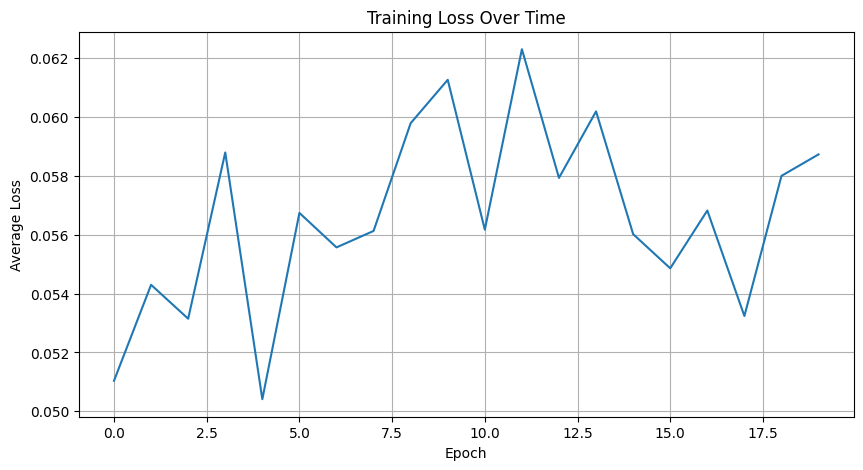

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Training Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

## Save the Fine-Tuned LoRA Weights

After the training is complete, we need to save our work. This cell saves the newly trained LoRA adapter weights—and only those weights—to the Google Drive path we mounted earlier. Because we only save the small adapter layers (a few megabytes) instead of the entire multi-gigabyte model, this process is fast and efficient.

In [ ]:
save_path = "/content/drive/MyDrive/GenAI_MDS_1546/zappos_shoe_lora"
# Use the PEFT model's save_pretrained method to save only the LoRA weights
pipe.unet.save_pretrained(save_path)
print("LoRA saved to", save_path)

LoRA saved to /content/drive/MyDrive/GenAI_MDS_1546/zappos_shoe_lora


## Inference and Interactive Demo

1. **Load Base Model:** We first load the original, unmodified Stable Diffusion v1.5 pipeline.

2. **Load LoRA Weights:** We then use load_attn_procs to load our custom shoe LoRA weights from Google Drive and apply them to the model's UNet. This dynamically infuses the base model with our specialized knowledge of shoes.

3. **Launch Gradio UI:** We create a simple, user-friendly web interface using Gradio. This interface provides a text box where you can enter a prompt. The generate function will then use the fine-tuned pipeline to create a shoe image and display it on the screen. The share=True argument generates a public URL, allowing anyone to try your model for a limited time.

In [ ]:
import gradio as gr
from diffusers import DiffusionPipeline
import torch
import os

# Reload the base pipeline
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

# Load the fine-tuned LoRA weights
save_path = "/content/drive/MyDrive/GenAI_MDS_1546/zappos_shoe_lora"
lora_weights_path = os.path.join(save_path, "unet") # Include the 'unet' subdirectory
print(lora_weights_path)
if os.path.exists(lora_weights_path):
    # Load the pipeline with LoRA weights
    pipe = DiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None, # Disable safety checker for faster inference
        low_cpu_mem_usage=True # Use low cpu memory
    ).to("cuda")
    pipe.unet.load_attn_procs(lora_weights_path)
    print("Loaded fine-tuned LoRA weights from", lora_weights_path)
else:
    print("No LoRA weights found at expected path. Running with the base model.")


# Set to evaluation mode for inference
pipe.unet.eval()

def generate(prompt, guidance_scale=7.5, num_steps=50):
    with torch.no_grad():
        image = pipe(
            prompt,
            guidance_scale=guidance_scale,
            num_inference_steps=num_steps
        ).images[0]
    return image

demo = gr.Interface(
    fn=generate,
    inputs=[
        gr.Textbox(label="Prompt", value="a photo of a shoe"),
        gr.Slider(minimum=1, maximum=20, step=0.5, value=7.5, label="Guidance Scale"),
        gr.Slider(minimum=10, maximum=100, step=1, value=50, label="Inference Steps")
    ],
    outputs=gr.Image(type="pil"),
    title="Generative AI Shoe Generator",
    description="Enter a prompt to generate a unique shoe design using a Stable Diffusion model fine-tuned with LoRA on the Zappos dataset.",
    allow_flagging="never"
)

demo.launch(share=True, debug=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA weights found at expected path. Running with the base model.


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c4d00d3db0a284436c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]